# **Homework 1 - Active Measurements**

## **Objective**
The purpose of the homework is to evaluate the relationship between the (average) RTT and the physical distance between two endpoints.

The source endpoint is fixed and it is represented by the physical machine on which the Colab VM is running, whereas the second endpoint is variable and placed at an increasing distance with respect to the first endpoint.




## **Development**

The solution to the homework covers three main points:

> ### **Selection of Endpoints**
The list of endpoints to be contacted from the local VM was scraped from this [page](https://www.debian.org/mirror/list). The webpage provides a sufficiently diverse collection of servers, located in different countries, to be used for the purpose of the assignemnt, allowing an estimation of RTT at both very short and very long distances.

> ### **RTT Estimation**
The estimation of RTT was performed using a custom `ping` implementation. In case the contacted server did not reply to the ICMP requests, TCP ping request were performed. In case in both circumnstances the server did not reply to the ping requests, the specific endpoint was discarded.

> ### **Fitting a Line to the Set of Measurements**
After having plotted the measurements on a distance/RTT graph, a line was fitted to the set of measurements retrieved in the previous steps. The objective was to check for evidence of correlation between distance and RTT.

## Select of Endpoints

As a first step, the list of endpoints to be contacted was scraped from the webapge at this [link](https://www.debian.org/mirror/list). This step significantly enhanced the level of automation of the solution to the homework.

In [ ]:
import requests
from bs4 import BeautifulSoup
from  urllib.parse import urlparse

# URL of the webpage from where to download the list of hostnames
url = "https://www.debian.org/mirror/list"

# Parameter used to conditionally select the portions of interest of the source HTML
selector = "table.center"

# Container for hostnames
hostnames = []

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
  # Parse the HTML of the page
  page = BeautifulSoup(response.text, 'html.parser')

  # Identify all subtrees within the DOM of the page that match the given selector
  subtrees = page.select(selector)

  if subtrees:
    # Iterate over each subtree
    for subtree in subtrees:
      # Find all anchor tags (links) within the subtree
      links = subtree.find_all('a')
      # Extract the href attribute from each anchor tag
      for link in links:
        href = link.get('href')
        if href:
          # Parse the URL to identify its components
          parsed_url = urlparse(href)
          # Extract the hostname
          hostname = parsed_url.hostname
          if hostname:
            # Add the hostname to the list of hostnames
            hostnames.append(hostname)
            print(hostname)

ftp.am.debian.org
ftp.au.debian.org
ftp.at.debian.org
ftp.by.debian.org
ftp.be.debian.org
ftp.br.debian.org
ftp.bg.debian.org
ftp.ca.debian.org
ftp.cl.debian.org
ftp.cn.debian.org
ftp.hr.debian.org
ftp.cz.debian.org
ftp.dk.debian.org
ftp.fi.debian.org
ftp.fr.debian.org
ftp2.de.debian.org
ftp.de.debian.org
ftp.hk.debian.org
ftp.is.debian.org
ftp.it.debian.org
ftp.jp.debian.org
ftp.kr.debian.org
ftp.lt.debian.org
ftp.md.debian.org
ftp.nl.debian.org
ftp.nc.debian.org
ftp.nz.debian.org
ftp.no.debian.org
ftp.pl.debian.org
ftp.pt.debian.org
ftp.ru.debian.org
ftp.sk.debian.org
ftp.si.debian.org
ftp.es.debian.org
ftp.se.debian.org
ftp.ch.debian.org
ftp.tw.debian.org
ftp.tr.debian.org
ftp.uk.debian.org
ftp.us.debian.org
debian.unnoba.edu.ar
ftp.am.debian.org
mirrors.asnet.am
ftp.au.debian.org
debian.mirror.digitalpacific.com.au
mirror.aarnet.edu.au
mirror.amaze.com.au
mirror.gsl.icu
mirror.linux.org.au
mirror.overthewire.com.au
mirror.realcompute.io
mirrors.xtom.au
ftp.at.debian.org
debian.anex

In [ ]:
# Print the number of hostnames retrieved
print("Number of downloaded hostnames: ",len(hostnames))

Number of downloaded hostnames:  373


In [ ]:
# Remove potential duplicates
hostnames = set(hostnames)

# Print the number of unique hostnames retrieved
print("Number of unique hostnames: ",len(hostnames))

Number of unique hostnames:  333


To avoid repeating the scraping procedure in future code executions and to enhance the reuse of data, the list of hostnames was stored in the form of CSV file.

In [ ]:
import csv

# Save data in the form of CSV file
with open("hostnames.csv", 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write each string from the set as a row in the CSV file
    for hostname in hostnames:
        csv_writer.writerow([hostname])

## Collect Measurements

After having collected the list of endpoints to be contacted from the local machine, the average RTT was estimated for each of them.

In [ ]:
! pip install --pre scapy[basic]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.5 MB/s eta 0:00:00
  Created wheel for scapy: filename=scapy-2.5.0-py2.py3-none-any.whl size=1444328 sha256=08dc82c56a7d6beeda077d7b7116032426eefca699a05adca09b8afba19c6d51
  Stored in directory: /root/.cache/pip/wheels/82/b7/03/8344d8cf6695624746311bc0d389e9d05535ca83c35f90241d
Successfully built scapy




For this purpose, a custom `ping` procedure was implemented, together with some utility functions.

In [ ]:
from scapy.all import *

# Compute RTT starting from a valid answer
def compute_rtt(ans):
  query = ans[0][0]
  resp = ans[0][1]
  RTT = (resp.time - query.sent_time)*1000 #in ms
  return RTT

# Make a ping request and return the computed RTT in case the host replies,
# return None otherwise
def ping(target,i):
  pck = IP(dst=target)/ICMP(seq=i)
  ans, unans = sr(pck, verbose=False, timeout=10)
  if(len(ans)>0) :
    return compute_rtt(ans)
  else:
    return None

# Make a TCP ping request and return the computed RTT in case the host replies,
# return None otherwise
def tcp_ping(target):
  tcp_syn = IP(dst=target)/TCP(dport = 80, flags = 'S')
  ans,unans = sr(tcp_syn, verbose=False, timeout=10)
  if(len(ans)>0):
    return compute_rtt(ans)
  else:
    return None

Each endpoint is pinged `num_request` times and then an average of the RTT values retrieved at each request is computed.

The `num_request` paramaeter is set to `10` by deafult. While increasing the number of requests would enhance the accuracy of the average RTT estimation, it would also extend the execution time of the procedure. Therefore, to strike a balance between precision and execution time, a value of `10` was selected. This choice took into account the fact that this procedure should have been invoked once for each endpoint in the list.

The procedure works as follows:
1. An ICMP ping request is sent `num_request` times to the target endpoint. Each time an answer is generated, the RTT is computed. The first time it occurs that a request doesn't get any reply, there is a switch in ping procedure: the endpint starts to reaceive TCP ping requests, instead of ICMP ones.

2. In case the target endpoint doesn't reply even to TCP requests, the first time the timeout expires and no answer is received, the host stops receiving ping requests. If this happens the first time a TCP ping is issued to the specific host and the host has never replied also to previous requests, the estimated RTT for that host is `None` and in future steps the host is discarded from the dataset.

In [ ]:
# Issue multiple ping requests to a target host,
# return the list of RTTs obtained
def make_ping_reqs(target,num_reqs=10):
  # List to store RTTs computed by seneding ping request to the target host
  RTTs = []
  # Boolean indicating if the host is being pinged with TCP syn messages or not
  tcp = False

  for i in range(num_reqs):
    if tcp == False:
      # Compute RTT by pinging the target host
      RTT = ping(target,i)
      if RTT:
        # Add RTT to the list of RTTs obtained through past ping messages
        RTTs.append(RTT)
      else:
        # In case the host does not reply to ping messages, switch to TCP requests
        tcp = True
        # Compute RTT by pinging the target host with a tcp syn message
        tcp_RTT = tcp_ping(target)
        if tcp_RTT:
          # Add RTT to the list of RTTs obtained through past TCP ping messages
          RTTs.append(tcp_RTT)
        else:
          break
    else:
      tcp_RTT = tcp_ping(target)
      if tcp_RTT:
        # Add RTT to the list of RTTs obtained through past TCP ping messages
        RTTs.append(tcp_RTT)
      else:
        # In case the host doesn't reply to TCP messages immediately stop sending it requests
        break

  if len(RTTs) > 0:
    # If the list of RTTs is not empty, return the average RTT across all requests
    return sum(RTTs)/len(RTTs)
  else:
    return None

In order to support the computation of the distance between the local and remote endpoints, details about the local machine are retrieved, including information like coordinates, city, country, etc.

The choice of parameters to be retrieved for the local machine was done in order for them to be the same as the ones retrieved in the subsequent steps for the remote endpoints.

In [ ]:
import urllib.request
import json
import socket

api = 'https://api.ipify.org'

# Retrieve local IP address
local_ip = urllib.request.urlopen(api).read().decode('UTF-8')

# Get the full set of properties associated with the IP address of the local machine
info = json.loads(urllib.request.urlopen('http://ip-api.com/json/'+local_ip).read())

local_hostname = socket.gethostbyaddr(local_ip)[0]
local_coordinates = []
local_coordinates.append(info['lat'])
local_coordinates.append(info['lon'])
local_city = info['city']
local_country = info['country']

print(f"Local machine hostname: {local_hostname}")
print(f"Local machine IP address: {local_ip}")
print(f"Local machine country: {info['country']}")
print(f"Local machine city: {info['city']}")
print(f"Local machine coordinates: {local_coordinates}")

Local machine hostname: 250.110.73.34.bc.googleusercontent.com
Local machine IP address: 34.73.110.250
Local machine country: United States
Local machine city: North Charleston
Local machine coordinates: [32.8771, -80.013]


The final dataset was built starting from a Python dictionary with all the endpoints' information.

Although for plotting the measurements only the `distance` and `avg_RTT` properties were needed, the choice of retaining additional details, such as city names or countries, stemmed from the willingness to present a more complete overview of the measurements collected. Additionally, such information was used for debugging purposes.

In [ ]:
from geopy.distance import distance

# Container for the endpoint's data
data = {
    "hostname": [],
    "ip_address": [],
    "country": [],
    "city": [],
    "coordinates": [],
    "distance": [],
    "avg_RTT": []
  }

# Iterate over the set of endpoints and retrieve a subset of their properties
for hostname in hostnames:
  # Get the IP address
  ip = socket.gethostbyname(hostname)
  # Get the full set of properties associated with the  given IP address
  info = json.loads(urllib.request.urlopen('http://ip-api.com/json/'+ip).read())

  data["hostname"].append(hostname)
  data["ip_address"].append(ip)
  data["country"].append(info["country"])
  data["city"].append(info["city"])
  coordinates = (info["lat"],info["lon"])
  data["coordinates"].append(coordinates)
  # Compute the distance in kilometers between the two endpoints
  dist = distance(tuple(local_coordinates),coordinates).km
  data["distance"].append(dist)
  # Average RTT
  avg_rtt = make_ping_reqs(hostname)
  data["avg_RTT"].append(avg_rtt)

Once having collected all the measurements, they are put together into a `pandas` DataFrame.

In [ ]:
import pandas as pd

# Iniitialize a DataFrama starting from the set of measurements collected
df = pd.DataFrame(data)
df

,hostname,ip_address,country,city,coordinates,distance,avg_RTT
0,mirror.keystealth.org,184.105.240.111,United States,Livermore,"(37.6864, -121.7654)",3804.166890,70.884418
1,ftp.belnet.be,193.190.198.27,Belgium,Brussels,"(50.8534, 4.347)",6883.431129,93.861222
2,mirror.johnnybegood.fr,136.243.89.31,Germany,Cologne,"(50.9663, 6.9564)",7052.432781,103.312731
3,ftp.psn.ru,217.26.17.81,Russia,Moscow,"(55.7558, 37.6173)",8551.907760,136.301637
4,mirrors.hostico.ro,188.241.222.52,Romania,Sighetu Marmaţiei,"(47.9307, 23.8892)",8299.665975,124.171066
...,...,...,...,...,...,...,...
328,opensource.nchc.org.tw,140.110.240.80,Taiwan,Hsinchu,"(24.8065, 120.9706)",13246.383299,192.884874
329,depot-debian.univ-reunion.fr,195.220.150.52,France,Paris,"(48.8566, 2.35222)",6817.229703,273.181129
330,mirror.datacenter.by,178.124.134.106,Belarus,Minsk,"(53.9007, 27.5709)",8157.837187,NaN
331,ftp.am.debian.org,93.187.162.100,Armenia,Yerevan,"(40.2047, 44.5398)",10114.653397,150.498176


In [ ]:
# Print the number of rows inside the df
print("Number of rows: ",len(df))

Number of rows:  333


Given that for some endpoints the average RTT couldn't be estimated, the corresponding rows were removed from the DataFrame.

In [ ]:
# Drop rows for which an estimation of the average RTT couldn't be done
df = df.dropna()

# Adjust df indexes
df = df.reset_index(drop=True)

# Print the number of well formed data points
print("Number of rows: ",len(df))

Number of rows:  327


The local endpoint is also added to the DataFrame with `0.0` values for both the `distance` and the `avg_RTT` fields.  This approach ensures that when plotting the set of measurements on a distance/RTT graph, a sample placed in the origin is included together with other data points.

In [ ]:
# Local machine dictionary
local_machine = {
  "hostname": local_hostname,
  "ip_address": local_ip,
  "country":local_country,
  "city": local_city,
  "coordinates": [tuple(local_coordinates)],
  "distance": 0.0,
  "avg_RTT": 0.0
}

# Convert the dictionary to a DataFrame
local_machine_df = pd.DataFrame(local_machine)

# Concatenate the local machine DataFrame with the one with all the measurements
df = pd.concat([local_machine_df,df], ignore_index=True)
df

,hostname,ip_address,country,city,coordinates,distance,avg_RTT
0,250.110.73.34.bc.googleusercontent.com,34.73.110.250,United States,North Charleston,"(32.8771, -80.013)",0.000000,0.000000
1,mirror.keystealth.org,184.105.240.111,United States,Livermore,"(37.6864, -121.7654)",3804.166890,70.884418
2,ftp.belnet.be,193.190.198.27,Belgium,Brussels,"(50.8534, 4.347)",6883.431129,93.861222
3,mirror.johnnybegood.fr,136.243.89.31,Germany,Cologne,"(50.9663, 6.9564)",7052.432781,103.312731
4,ftp.psn.ru,217.26.17.81,Russia,Moscow,"(55.7558, 37.6173)",8551.907760,136.301637
...,...,...,...,...,...,...,...
323,debian.mirror.lrz.de,129.187.10.100,Germany,Munich,"(48.1663, 11.5683)",7479.137647,106.748772
324,opensource.nchc.org.tw,140.110.240.80,Taiwan,Hsinchu,"(24.8065, 120.9706)",13246.383299,192.884874
325,depot-debian.univ-reunion.fr,195.220.150.52,France,Paris,"(48.8566, 2.35222)",6817.229703,273.181129
326,ftp.am.debian.org,93.187.162.100,Armenia,Yerevan,"(40.2047, 44.5398)",10114.653397,150.498176


Rows inside the DataFrame are then arranged in ascending order, based on their distance from the first endpoint. This is a preliminary step needed to correclty plot data.

In [ ]:
# Arrange values in ascending order based on their distance from the first endpoint
df = df.sort_values(by="distance", ascending = True)

# Adjust df indexes
df = df.reset_index(drop=True)
df

,hostname,ip_address,country,city,coordinates,distance,avg_RTT
0,250.110.73.34.bc.googleusercontent.com,34.73.110.250,United States,North Charleston,"(32.8771, -80.013)",0.000000,0.000000
1,atl.mirrors.clouvider.net,92.119.16.152,United States,Atlanta,"(33.7485, -84.3871)",418.596227,10.605025
2,debian-archive.trafficmanager.net,40.76.167.129,United States,Boydton,"(36.677696, -78.37471)",447.476694,18.288350
3,mirror.us.leaseweb.net,207.244.94.80,United States,Manassas,"(38.7514, -77.5251)",689.395239,13.096976
4,mirror.i3d.net,104.153.87.214,United States,Ashburn,"(39.018, -77.539)",716.925758,18.699288
...,...,...,...,...,...,...,...
323,ossmirror.mycloud.services,202.79.180.254,Singapore,Singapore,"(1.28324, 103.852)",16201.482303,217.872500
324,mirror.unair.ac.id,210.57.214.83,Indonesia,Surabaya,"(-7.2484, 112.7419)",16880.179480,239.779425
325,kebo.pens.ac.id,202.9.85.18,Indonesia,Surabaya,"(-7.27585, 112.794)",16880.738486,237.890124
326,mirror.poliwangi.ac.id,103.109.210.9,Indonesia,Banyuwangi,"(-8.2471, 114.3878)",16905.431254,244.200516


To keep a record of the measurements performed, they are stored in the form of CSV file.

In [ ]:
# Save df to CSV
df.to_csv("measurements.csv", index=False)

## Plot Measurements

To inspect the relationship between distance and RTT, measurements are plotted on a 2D graph.

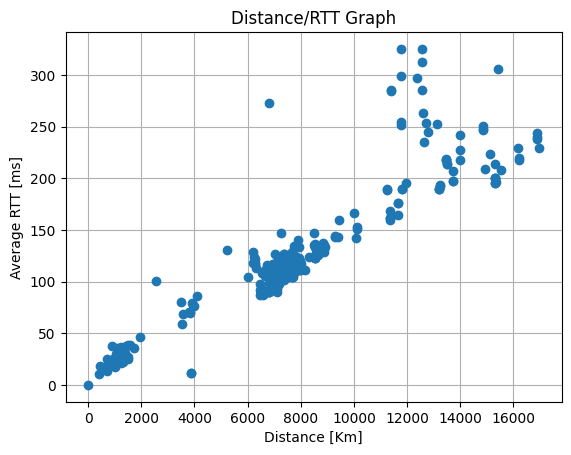

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
plt.plot(df["distance"],df["avg_RTT"], 'o')

plt.xlabel("Distance [Km]")
plt.ylabel("Average RTT [ms]")
plt.title("Distance/RTT Graph")
# Maximum distance recorded
max_distance = df["distance"].max()
plt.xticks(np.arange(0,max_distance,step = 2000))
plt.grid(visible=True)

## Fit a Linear Function to Data

A basic approximation for the RTT is a linear function of the physical distance:

\begin{align}
RTT  = 2 \times \left(\frac{L}{C} + \frac{d}{v}\right) + n
\end{align}

where:
- $RTT$ is the Round-Trip Time
- $L$ is the packet size
- $C$ is the capacity of the link
- $d$ is the fistance travelled by the packet
- $v$ is the speed of propagation of the signal
- $n$ is the processing time at each node

But given that all terms are negligible  compared to the propagation delay term ($\frac{d}{v}$), which represents the time taken for the packet to propagate across the distance ($d$), we can approximate the $RTT$ with the following formula:

\begin{align}
RTT  = 2 \times \frac{d}{v}
\end{align}

In the 2D plane, this is a line (polynomial of degree 1). We will use this line as reference when eveluating the quality of the linear function fitted over the set of measurements.

Given that the relationship existing between distance and RTT is linear, we check for evidence of correlation between the two by fitting data collected in previous steps to a line. We then reason on the slope of the fitted line to asses the quality of the linear model obtained.

In [ ]:
# Polynomial degree
deg = 1

# Parameters of the fitted line
weights = np.polyfit(df["distance"],df["avg_RTT"],deg)

# Equation of the fitted line
fitted_line = np.poly1d(weights)

# Slope of the fitted line
slope = fitted_line[1]

print("Fitted Line: y = ",fitted_line)
print("Slope: ",slope)

Fitted Line: y =    
0.01544 x + 2.531
Slope:  0.015438427908444668


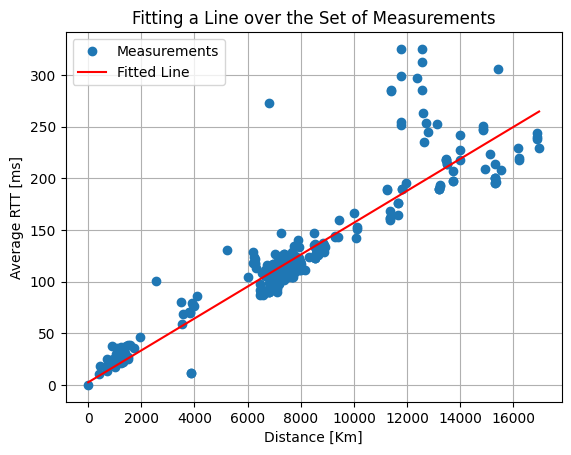

In [ ]:
x = np.linspace(0, max_distance, 2000)
# Evaluate the fitted function at x values
y = fitted_line(x)

# Plot the measurements previously collected
plt.plot(df["distance"],df["avg_RTT"], "o",label="Measurements");
# Plot the fitted line
plt.plot(x, y, "r", label="Fitted Line")

plt.xlabel("Distance [Km]")
plt.ylabel("Average RTT [ms]")
plt.title("Fitting a Line over the Set of Measurements")
plt.legend()
plt.xticks(np.arange(0,max_distance,step = 2000))
plt.grid(True)

We obtained a line representing the average RTT per kilometer. To check its correctness we need to go back to the RTT approximated formula. We could say that the slope of the line it represents is given by the $\frac{2}{v}$ coefficient.

\begin{align}
Slope  = \frac{2}{v}
\end{align}

Now, considering the slope of the fitted line, we can estimate the average propagation speed over the set of measurements from which the fitted line was build.

In [ ]:
# Estimated propagation speed
v = 2/slope
print(f"{v: .3f} [km/ms]")

 129.547 [km/ms]


In many practical scenarios, like those in which signals are propagated through fiber optic cables, the propagation speed can be approximated with 200 000 km/s (= 200 km/ms, using the a unit measure coherent with the data available).

We can compare this propagation speed with the one estimated from the fitted model and check if the order of magnitude between the two is analogous.


In [ ]:
# Propagation speed in fiber optic
propagation_speed = 200.000 #km/ms

proportion = (propagation_speed - v)/propagation_speed * 100
print(f"The estimated propagation speed is {proportion :.2f}% smaller than the propagation speed in fiber optic")

The estimated propagation speed is 35.23% smaller than the propagation speed in fiber optic


We can cocnlude that the order of magnitued between the two propagation speed values is the same.

However the estimated speed is smaller than its nominal value in fiber optic. This difference can be determined by various factors that in practical scenarios introduce additional latencies in the propagation of the signal, resulting in a reduced propagation speed.